In [1]:
import mir_eval
import numpy as np
import os
import pandas as pd
import sys
sys.path.append('../src')
import localmodule


# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
trials = [5, 7, 9, 7, 7, 8] # maximize clip-wise val acc
icassp_thresholds = 1.0 - np.logspace(-7, 0, 141)[::-1]
n_thresholds = len(thresholds)
tolerance = 0.5 # in seconds


# Define directory for model.
aug_str = "all"
model_name = "icassp-convnet"
if not aug_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_str])
model_dir = os.path.join(models_dir, model_name)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))

# Loop over recording units.
for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = trials[test_unit_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(unit_dir, trial_str)
    prediction_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-predictions.csv"])
    prediction_path = os.path.join(trial_dir, prediction_name)
    prediction_df = pd.read_csv(prediction_path)

    annotation_path = os.path.join(annotations_dir,
        test_unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    n_relevant = len(relevant)

    y_pred = np.array(prediction_df["Predicted probability"])
    timestamps = np.array(prediction_df["Timestamp"])


    for th_id, threshold in enumerate(icassp_thresholds):
        selected = timestamps[y_pred > threshold]

        selected_relevant = mir_eval.util.match_events(
            relevant, selected, tolerance)

        true_positives = len(selected_relevant)
        n_selected = len(selected)
        false_positives = n_selected - true_positives
        false_negatives = n_relevant - true_positives

        tp_matrix[th_id, test_unit_id] = true_positives
        fp_matrix[th_id, test_unit_id] = false_positives
        fn_matrix[th_id, test_unit_id] = false_negatives
        
        
icassp_tp = np.sum(tp_matrix, axis=1)
icassp_fp = np.sum(fp_matrix, axis=1)
icassp_fn = np.sum(fn_matrix, axis=1)

icassp_precisions = 100 * icassp_tp / (icassp_tp+icassp_fp)
icassp_recalls = 100 * icassp_tp / (icassp_tp+icassp_fn)
icassp_f1_scores = 2*icassp_precisions*icassp_recalls /\
    (icassp_precisions+icassp_recalls)
    

icassp_precisions = [0.0] + list(icassp_precisions) + [100.0]
icassp_recalls = [100.0] + list(icassp_recalls) + [0.0]
icass_f1_scores = [0.0] + list(icassp_f1_scores) + [0.0]

In [2]:
models_dir = localmodule.get_models_dir()
model_name = "SKM"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)

unit_relevant = []
unit_selected, unit_tp = [], []
for unit_str in units:
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([model_name, tol_str, unit_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    precisions = np.array(df["precision (%)"])
    precisions = np.insert(precisions, 0, 0.0)
    precisions = np.append(precisions, 100)
    precisions = precisions[::-1] / 100
    recalls = np.array(df["recall (%)"])
    recalls = np.insert(recalls, 0, 100.0)
    recalls = np.append(recalls, 0.0)
    recalls = recalls[::-1] / 100
    unit_relevant.append(np.array(df["relevant"])[0])
    unit_selected.append(np.array(df["selected"]))
    unit_tp.append(np.array(df["true positives"]))
    

relevant = np.sum(np.array(unit_relevant))
selected = np.sum(np.stack(unit_selected), axis=0)
tp = np.sum(np.stack(unit_tp), axis=0)
precisions = tp / selected
recalls = tp / relevant
precisions = np.insert(precisions, 0, 0.0)
precisions = np.append(precisions, 1.0)
precisions = 100 * precisions[::-1]
recalls = np.insert(recalls, 0, 1.0)
recalls = np.append(recalls, 0.0)
recalls = 100 * recalls[::-1]

skm_precisions = precisions
skm_recalls = recalls
skm_f1_scores = 2*skm_precisions*skm_recalls / (skm_precisions+skm_recalls)

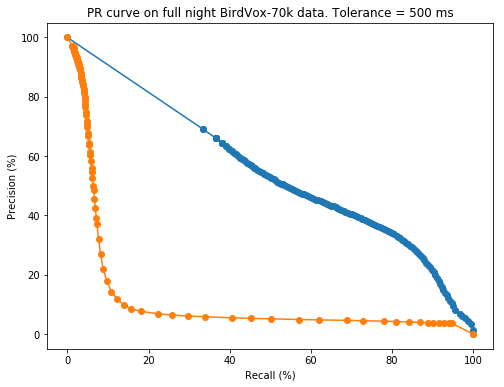

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.plot(icassp_recalls, icassp_precisions, "-o", skm_recalls, skm_precisions, "-o")
plt.title("PR curve on full night BirdVox-70k data. Tolerance = {} ms".format(tolerance_ms))
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")

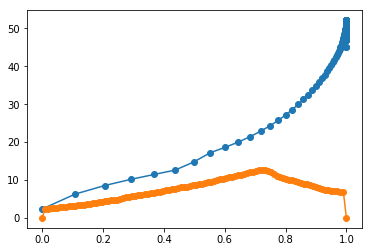

In [21]:
plt.plot(icassp_thresholds, icassp_f1_scores, '-o', np.linspace(0.0, 1.0, 102), skm_f1_scores, '-o')

In [17]:
icassp_thresholds = 1.0 - np.logspace(-7, 0, 141)[::-1]